# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt

%run ../src/mGST/reporting.py

### Setting the parameters

In [3]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
rK = 1   # rank of the model estimate
n_povm = 2   # number of POVM-elements

meas_samples = 1e4

### Loading data

In [31]:
with open('data/qw5q-qubit1-fast.json') as f:
    data = json.load(f)
print(data.keys())
J = np.array(data['sequences'])[:,::-1]
y = np.array(data['hardware_probabilities']).T

dict_keys(['nsequences', 'sequence_creation_time', 'execution_time', 'sequences', 'hardware_probabilities', 'platform', 'qubit', 'depth', 'nshots'])


### GST

Starting optimization...
 15%|██████▎                                   | 15/100 [00:03<00:17,  4.74it/s]


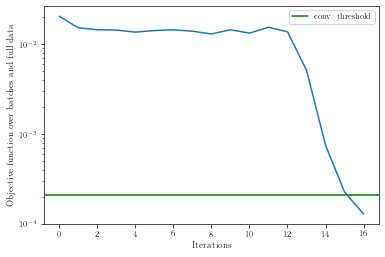

Optimization successful, improving estimate over full data....
 11%|████▉                                       | 9/80 [00:02<00:18,  3.88it/s]


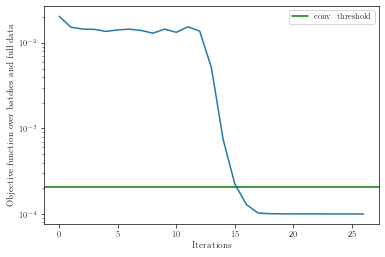

#################
	 Convergence criterion satisfied
	 Final objective function value 0.00010015627025959984 with # of initializations: 1 
 	 Total runtime: 5.769546747207642
Starting optimization...
 19%|███████▉                                  | 19/100 [00:09<00:39,  2.04it/s]


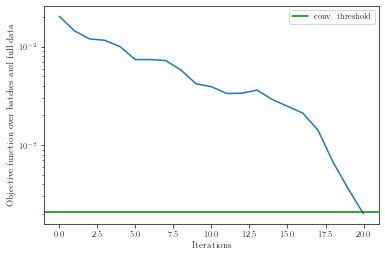

Optimization successful, improving estimate over full data....
 36%|███████████████▌                           | 29/80 [00:20<00:36,  1.39it/s]


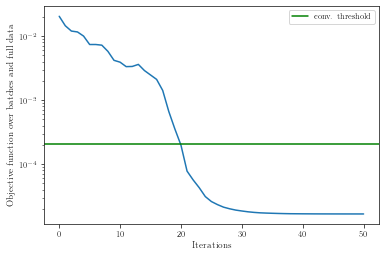

#################
	 Convergence criterion satisfied
	 Final objective function value 1.6709967560952188e-05 with # of initializations: 1 
 	 Total runtime: 30.60930562019348


In [32]:
bsize = 50   # The batch size on which the optimization is started

results = []
for rK in [1,4]: 
    X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #The idle-X(pi/w)-Y(pi/2) model 
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    X_t = np.einsum('ijkl,ijnm -> iknlm', K_t, K_t.conj()).reshape(d,r,r)  
    K,X,E,rho,res_list = algorithm.run_mGST(y,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 20, max_iter = 100, final_iter = 80, threshold_multiplier = 10, 
                         target_rel_prec = 1e-5, init = [K_t, E_t, rho_t], testing = True)   
    results.append([K,X,E,rho])

### Save data

In [33]:
# ###################################### 
# filename = 'results-qubit1-fast'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1,4],'phys. dimension':int(np.sqrt(r)), 'Sequence count': len(J), 
#               'J':J,'y':y,'threshold_multiplier': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

### Rank 1

In [35]:
for i in range(1,4):
    filename = "results-qubit%i-fast"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    results = b['results']

    # Performance metrics rank 1
    print("\n", filename)
    K,X,E,rho = results[0][:]
    J = b['parameters']['J']
    y = b['parameters']['y']

    weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
    display(s_g), display(s_o)   


 results-qubit1-fast


,F_avg,Diamond distances
Id,"0,99663","0,07110"
Rx(pi/2),"0,99989","0,01279"
Ry(pi/2),"0,99992","0,01126"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000100,0.007530,0.121432,0.102657,0.101379



 results-qubit2-fast


,F_avg,Diamond distances
Id,"0,99124","0,11462"
Rx(pi/2),"0,99946","0,02845"
Ry(pi/2),"0,99945","0,02883"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000041,0.004969,0.122045,0.082250,0.083749



 results-qubit3-fast


,F_avg,Diamond distances
Id,"0,99947","0,02831"
Rx(pi/2),"0,99991","0,01181"
Ry(pi/2),"0,99990","0,01246"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000036,0.004868,0.053052,0.042236,0.055020


### Rank 4

In [37]:
for i in range(1,4):
    filename = "results-qubit%i-fast"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    results = b['results']

    # Performance metrics rank 4
    print("\n", filename)
    K,X,E,rho = results[1][:]
    J = b['parameters']['J']
    y = b['parameters']['y']
    
    weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
    display(s_g), display(s_o)   


 results-qubit1-fast


,F_avg,Diamond distances
Id,"0,98384","0,08122"
Rx(pi/2),"0,98337","0,05048"
Ry(pi/2),"0,98468","0,04709"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003181,0.121432,0.088033,0.040173



 results-qubit2-fast


,F_avg,Diamond distances
Id,"0,98562","0,11697"
Rx(pi/2),"0,99092","0,04480"
Ry(pi/2),"0,99228","0,04175"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000018,0.003462,0.122045,0.077274,0.074279



 results-qubit3-fast


,F_avg,Diamond distances
Id,"0,99145","0,03491"
Rx(pi/2),"0,99247","0,02693"
Ry(pi/2),"0,99233","0,02613"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003252,0.053052,0.036470,0.018129


### Gate plots


 results-qubit1-fast


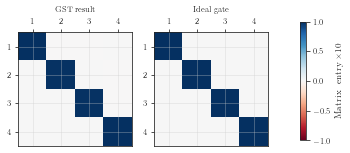

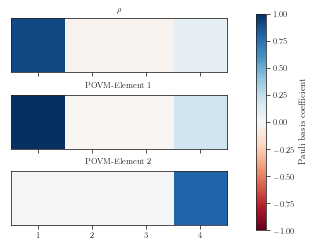

In [41]:
filename = "results-qubit1-fast"
with open(filename, 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

# Performance metrics rank 1
print("\n", filename)
K,X,E,rho = results[0][:]
J = b['parameters']['J']
y = b['parameters']['y']

weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)

plot_mat(X_opt[0], X_t[0])
plot_spam(rho_opt, E_opt)